<b><font size="6">|032|ANN|Vehicle Price Prediction</font></b>

* **Author**: Dino Giovannoni
* **Date:**: 20-April-2025

Based on dataset: https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho/data
Notebook based on: 
 - https://www.kaggle.com/code/farzadnekouei/polynomial-regression-regularization-assumptions
 - https://www.kaggle.com/code/mohaiminul101/car-price-prediction

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load the Data

In [2]:
df = pd.read_csv('car data.csv')

## Inspect the first 5 rows

In [3]:
display(df.head())

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


## Inspect information about the dataframe 

Provide a list of the DataFrame columns and the data types in each of the columns.

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


None

# Data Processing & Exploratory Data Analysis

## View the Descriptive Statistics

Extract various descriptive statistics from the dataset, including the mean/standard deviation, mmin, max, etc.

In [5]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Year,301.0,2013.627907,2.891554,2003.00,2012.0,2014.0,2016.0,2018.0
Selling_Price,301.0,4.661296,5.082812,0.10,0.9,3.6,6.0,35.0
Present_Price,301.0,7.628472,8.644115,0.32,1.2,6.4,9.9,92.6
Kms_Driven,301.0,36947.205980,38886.883882,500.00,15000.0,32000.0,48767.0,500000.0
Owner,301.0,0.043189,0.247915,0.00,0.0,0.0,0.0,3.0


## Feature Transformation - Year

"Year" shows the car model year. We can replace this column with the cars age attribute.To calculate the age, we consider the origin time to be 1 year older than the maximum model year:

In [6]:
df = df.assign(Age = lambda df_: df_["Year"].max() + 1 - df_["Year"])
df.drop('Year', axis=1, inplace=True)
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Selling_Price,301.0,4.661296,5.082812,0.10,0.9,3.6,6.0,35.0
Present_Price,301.0,7.628472,8.644115,0.32,1.2,6.4,9.9,92.6
Kms_Driven,301.0,36947.205980,38886.883882,500.00,15000.0,32000.0,48767.0,500000.0
Owner,301.0,0.043189,0.247915,0.00,0.0,0.0,0.0,3.0
Age,301.0,5.372093,2.891554,1.00,3.0,5.0,7.0,16.0


## Feature Selection

Since Car_Name contains 98 unique categories, and this number of categories is very high compared to the number of dataset samples, it is better to drop it:

In [7]:
df.drop('Car_Name', axis=1, inplace=True)

We can determine which are the numerical and categorical features:

In [8]:
output_var = 'Selling_Price'
numeric_data = df.select_dtypes(include=['number']).columns.tolist()
numeric_features = [col for col in numeric_data if col != output_var]
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f'Numeric Features    : {numeric_features}')
print(f'Categorical Features: {categorical_features}')

Numeric Features    : ['Present_Price', 'Kms_Driven', 'Owner', 'Age']
Categorical Features: ['Fuel_Type', 'Seller_Type', 'Transmission']


## Histograms of Numerical Raw Features

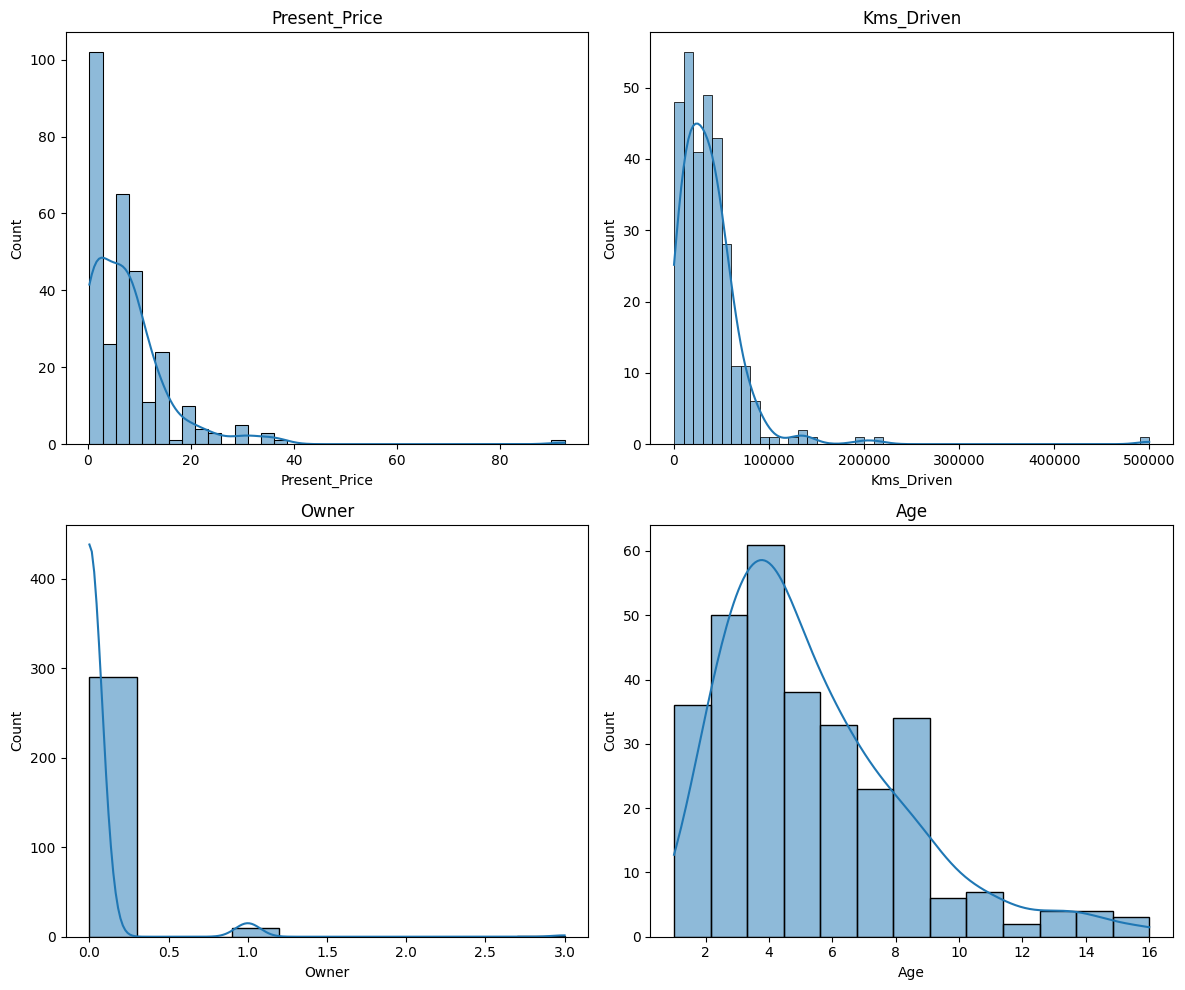

In [9]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(df[numeric_features].columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

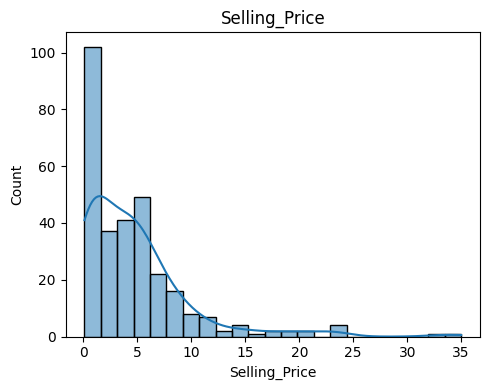

In [10]:
plt.figure(figsize=(5, 4))
sns.histplot(df[output_var], kde=True)
plt.title(output_var)
plt.tight_layout()
plt.show()

## Transformation of Skewed Data

All the numeric data seems to be right-skewed. Let's confirm this by looking at the skewness coefficient for all the numerical columns:

In [11]:
for col in numeric_data:
    print(f'{col} = {df[col].skew()}')

Selling_Price = 2.493422417797524
Present_Price = 4.083150156592918
Kms_Driven = 6.436012679752193
Owner = 7.616849679389442
Age = 1.2461891109537502


For all the columns, the kewness coefficient is greater that 1, so they are all highly skewed. Since the Owner contains 0 values, we need a transformation that can deal with zero-values. We could use a log1p transformation, but lets use the Yeo-Johnson transformer.

In [12]:
pt = PowerTransformer(method='yeo-johnson')

df_transformed = df.copy()
df_transformed[numeric_data] = pt.fit_transform(df[numeric_data])

### Statistics of Transformed Data

In [13]:
display(df_transformed.describe().T)

,count,mean,std,min,25%,50%,75%,max
Selling_Price,301.0,1.888486e-16,1.001665,-1.690727,-0.957921,0.169748,0.681225,2.538367
Present_Price,301.0,-1.652425e-16,1.001665,-1.640607,-1.090967,0.244612,0.680200,3.182202
Kms_Driven,301.0,1.829470e-16,1.001665,-2.679837,-0.638029,0.141104,0.650039,4.822699
Owner,301.0,-1.770455e-17,1.001665,-0.194759,-0.194759,-0.194759,-0.194759,5.134553
Age,301.0,5.901518e-18,1.001665,-2.856946,-0.879888,0.127786,0.783425,2.294062


### Histograms of Transformed Numeric Features

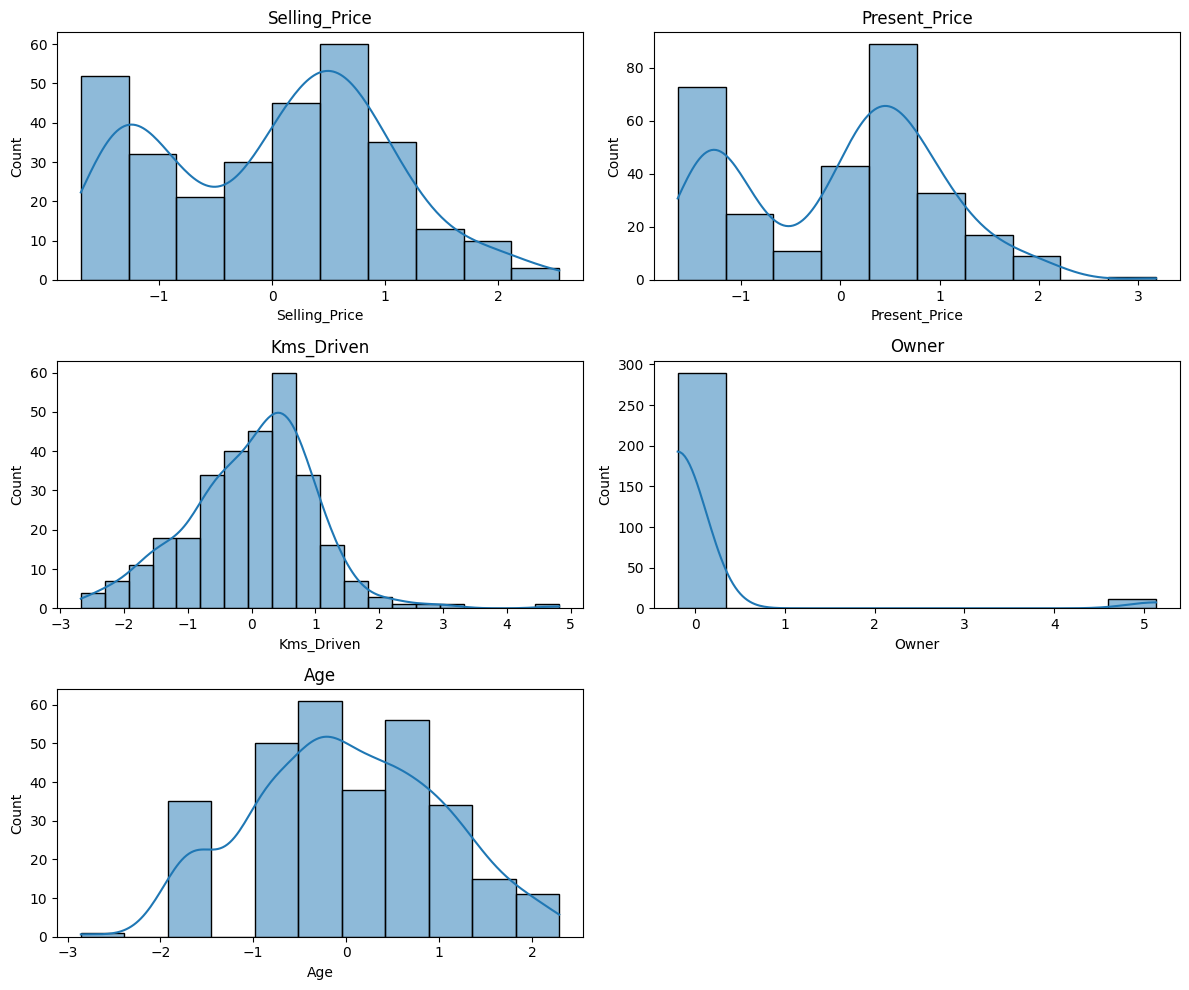

In [14]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(df_transformed[numeric_data].columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(df_transformed[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

### Box Plots of Transformed Numeric Features

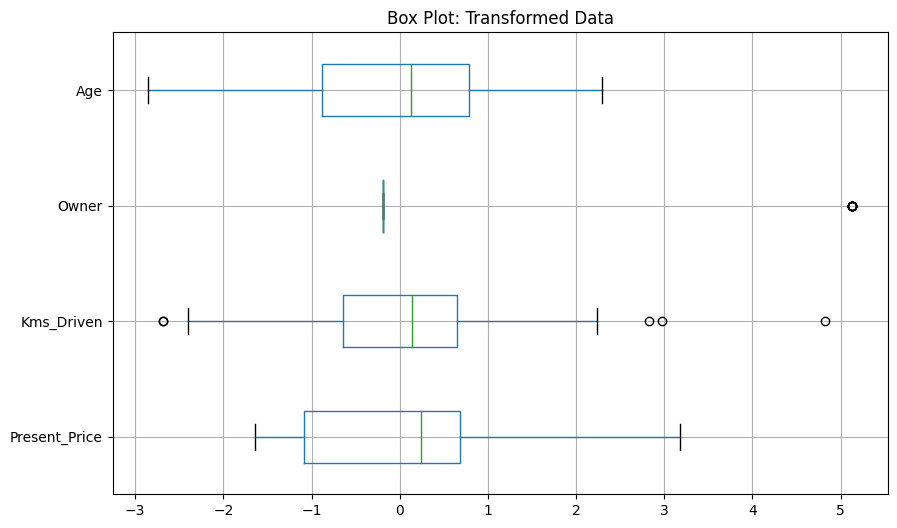

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = df_transformed[numeric_features].boxplot(vert = 0, ax=ax)  
_ = ax.set_title(f'Box Plot: Transformed Data')

## Scaling of all numeric data

While not strictly necessary, let's scale the transformed data to be in the range 0-2. For this we use the MinMaxScler.

In [16]:
scaler = MinMaxScaler(feature_range=(0, 2))
scaler.fit(df_transformed[numeric_data])

df_transformed[numeric_data] = scaler.transform(df_transformed[numeric_data])

### Histograms of Transformed & Scaled Numeric Features

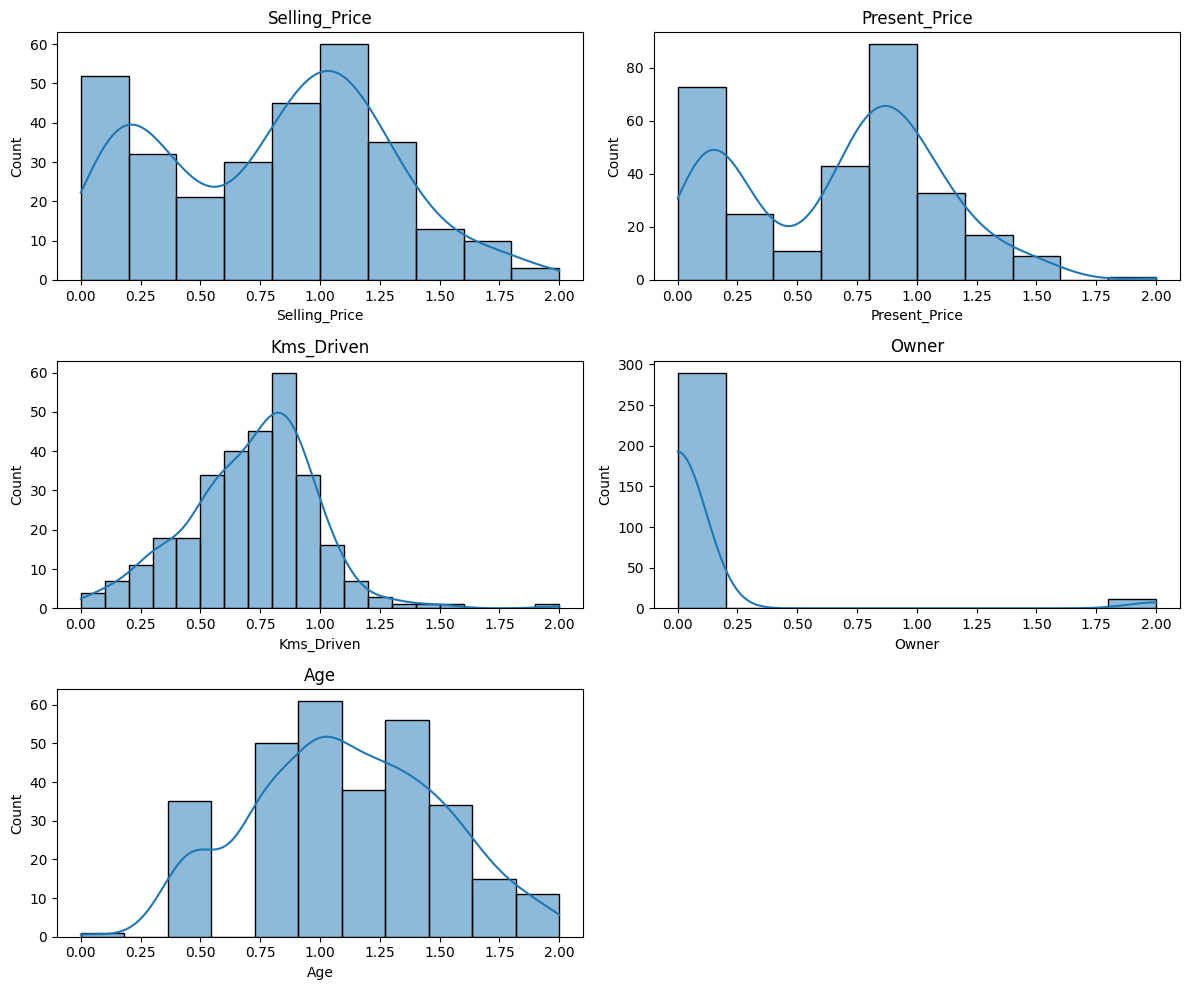

In [17]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(df_transformed[numeric_data].columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(df_transformed[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

## Categorical Data

In [18]:
print(f'Categorical Features: {categorical_features}')

Categorical Features: ['Fuel_Type', 'Seller_Type', 'Transmission']


In [19]:
display(df.describe(include='object').T)

,count,unique,top,freq
Fuel_Type,301,3,Petrol,239
Seller_Type,301,2,Dealer,195
Transmission,301,2,Manual,261


### Frequency Distributions

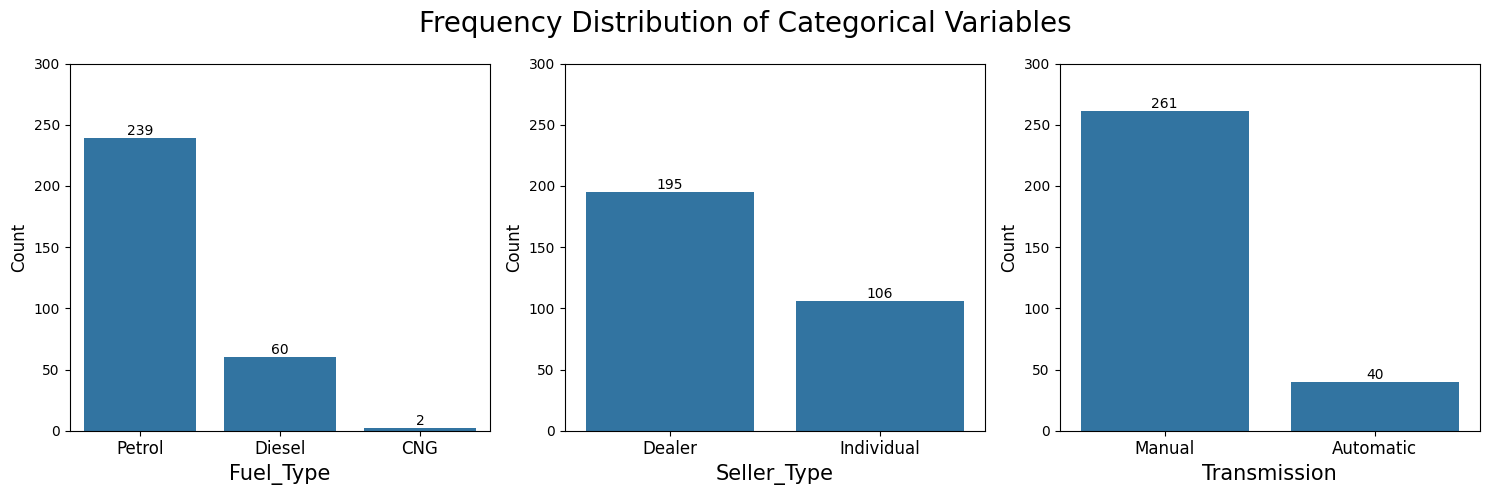

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), dpi=100)
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
       
for i in range(len(categorical_features)):
    graph = sns.countplot(x=categorical_features[i], data=df_transformed, ax=ax[i])
    ax[i].set_xlabel(categorical_features[i], fontsize=15)
    ax[i].set_ylabel('Count', fontsize=12)
    ax[i].set_ylim([0,300])
    ax[i].tick_params(axis='x', labelsize=12)
    for cont in graph.containers:
        graph.bar_label(cont)

plt.suptitle('Frequency Distribution of Categorical Variables', fontsize=20) 
plt.tight_layout()
plt.show()

### Categorical Variables Encoding

We implement dummy encoding on categorical columns, since they are all nominal variables:

In [21]:
df_transformed = pd.get_dummies(df_transformed, columns=categorical_features, drop_first=True)
df_transformed.head(5)

,Selling_Price,Present_Price,Kms_Driven,Owner,Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,0.847112,0.728084,0.701586,0.0,1.158892,False,True,False,True
1,1.009288,0.946691,0.845480,0.0,1.297567,True,False,False,True
2,1.214467,0.960274,0.371942,0.0,0.465054,False,True,False,True
3,0.775139,0.614405,0.317768,0.0,1.512530,False,True,False,True
4,0.994060,0.810390,0.841246,0.0,1.158892,True,False,False,True


## Outlier Detection and removal

In [22]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Selling_Price           301 non-null    float64
 1   Present_Price           301 non-null    float64
 2   Kms_Driven              301 non-null    float64
 3   Owner                   301 non-null    float64
 4   Age                     301 non-null    float64
 5   Fuel_Type_Diesel        301 non-null    bool   
 6   Fuel_Type_Petrol        301 non-null    bool   
 7   Seller_Type_Individual  301 non-null    bool   
 8   Transmission_Manual     301 non-null    bool   
dtypes: bool(4), float64(5)
memory usage: 13.1 KB


In [23]:
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(df_transformed)
df_cleaned = df_transformed[outliers == 1]
display(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 298 entries, 0 to 300
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Selling_Price           298 non-null    float64
 1   Present_Price           298 non-null    float64
 2   Kms_Driven              298 non-null    float64
 3   Owner                   298 non-null    float64
 4   Age                     298 non-null    float64
 5   Fuel_Type_Diesel        298 non-null    bool   
 6   Fuel_Type_Petrol        298 non-null    bool   
 7   Seller_Type_Individual  298 non-null    bool   
 8   Transmission_Manual     298 non-null    bool   
dtypes: bool(4), float64(5)
memory usage: 15.1 KB


None

### Box Plots of Transformed Numeric Features

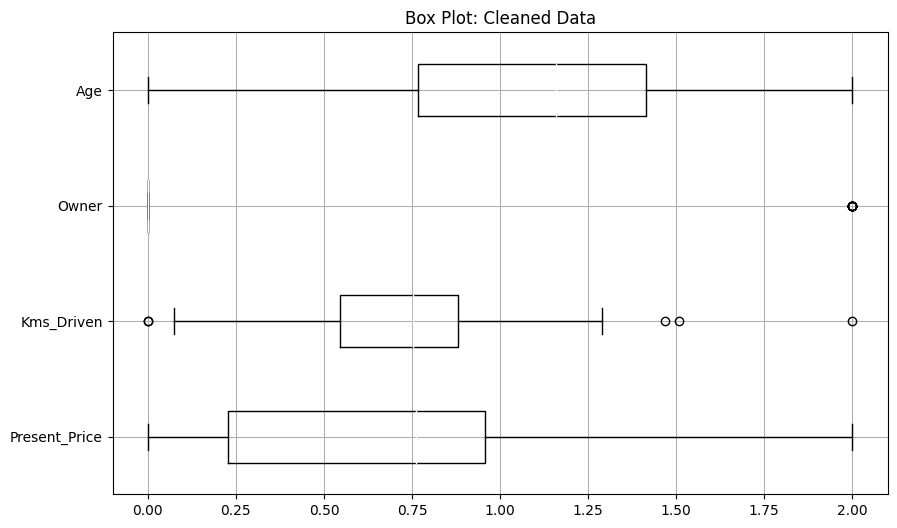

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = df_cleaned[numeric_features].boxplot(vert = 0, ax=ax)  
_ = ax.set_title(f'Box Plot: Cleaned Data')

## Create Scatter Plots of Data

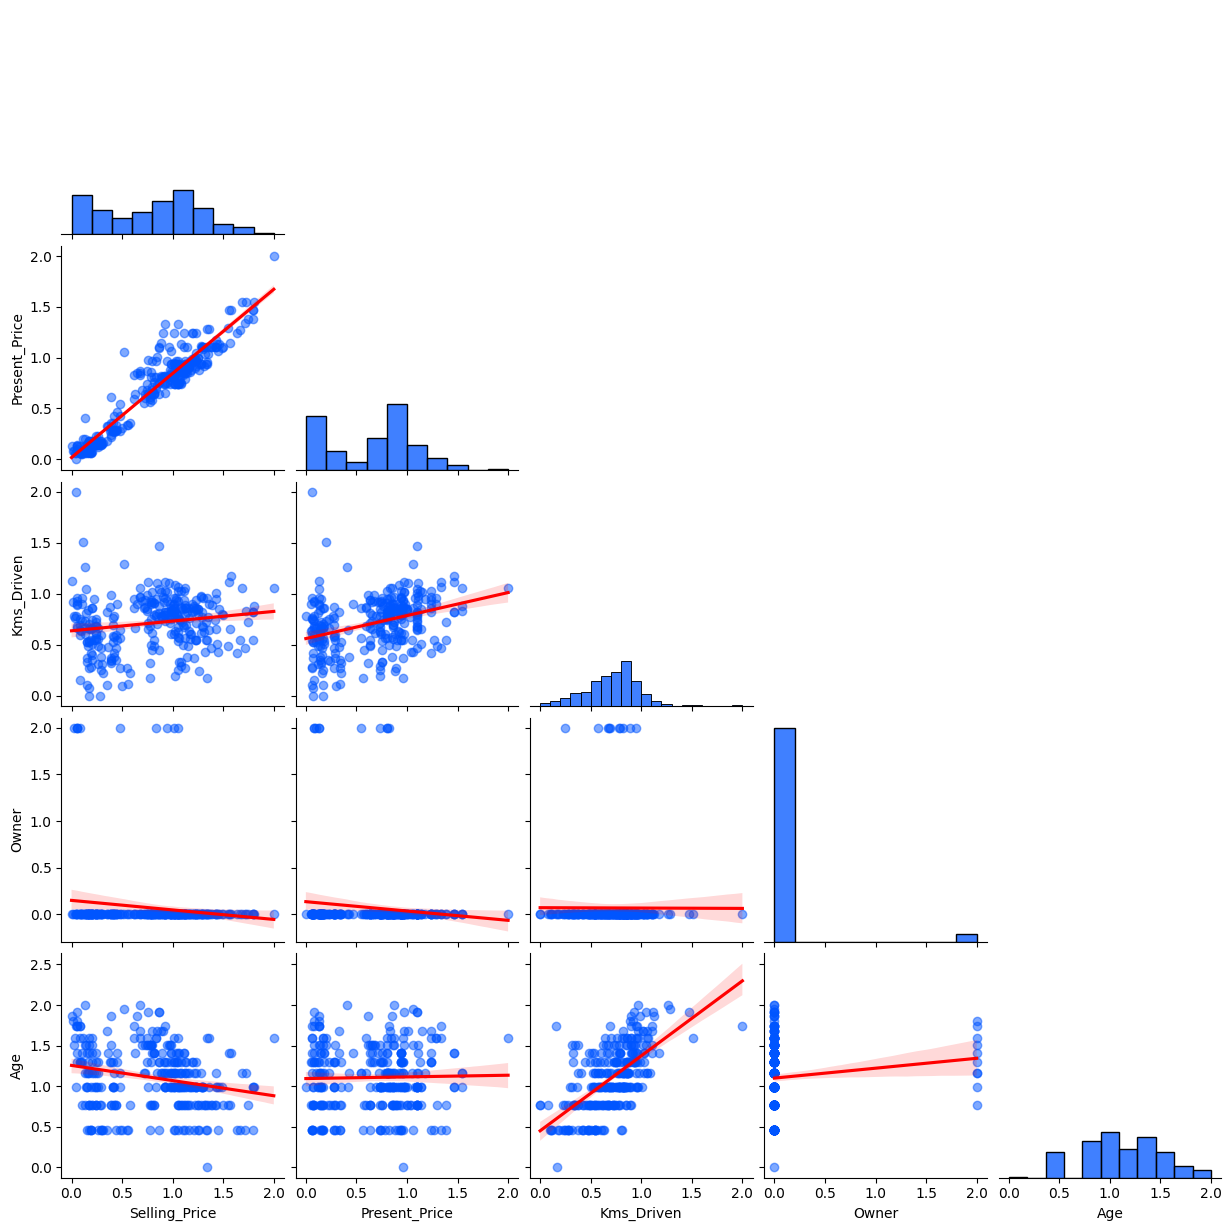

In [25]:
_ = sns.pairplot(data = df_cleaned[numeric_data], 
                 corner = True, 
                 kind='reg',
                 plot_kws={'line_kws': {'color': 'red'}, 'scatter_kws': {'alpha': 0.5}})

In [26]:
# x_name = 'Disney movies released'
# y_name = 'Divorce rates in the United Kingdom'

# ax = df.plot.scatter(x=x_name, y=y_name, c='blue', s=10)

## Calculate the correlation coeffients

In [27]:
def CorrPlot(df, dropDuplicates = True, figsize = (8, 6)):
    # df = df.corr()
    df = np.abs(df.corr())
    # Exclude duplicate correlations by masking upper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    # Set background color / chart style
    sns.set_style(style = 'white')
    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                    annot=True,
                    square=True,
                    linewidth=.5, cbar_kws={"shrink": .75}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                annot=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

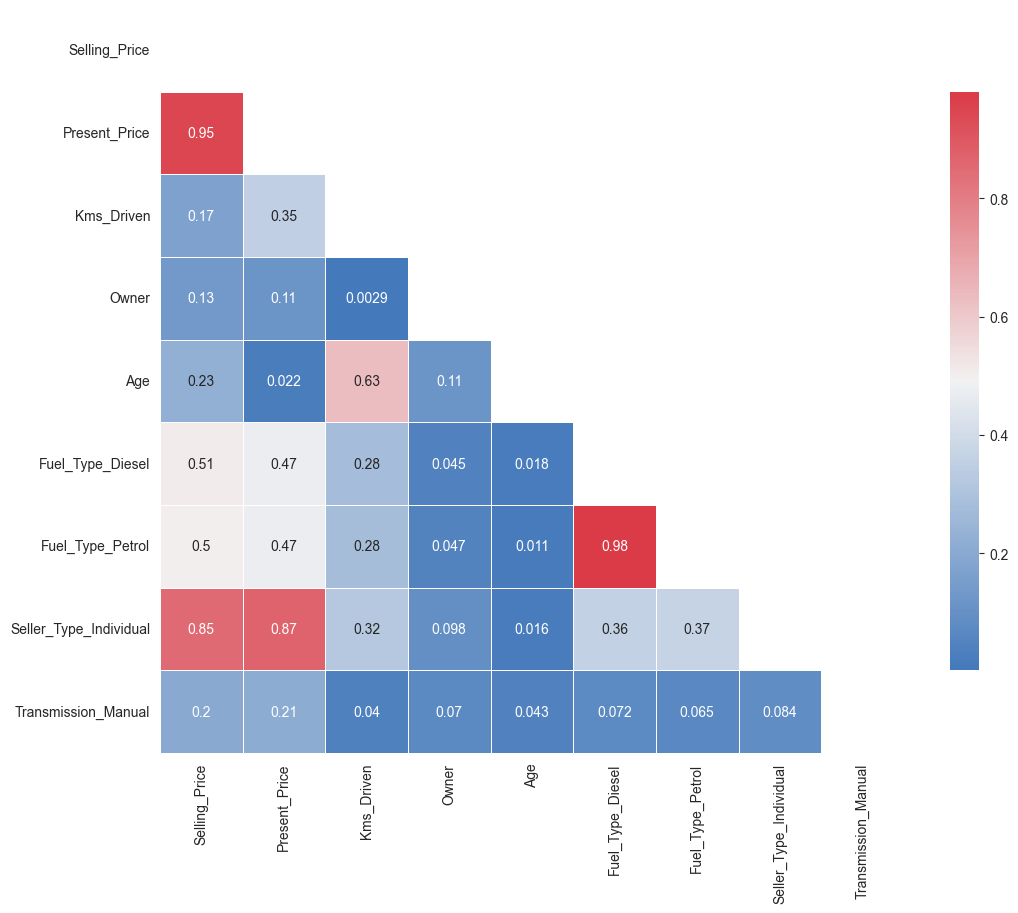

In [28]:
CorrPlot(df_cleaned, figsize = (12, 10))

### Feature Selection - Correlations

We see that the lowest correlation coefficient is with Owner. Let's remove it.

In [29]:
df_cleaned = df_cleaned.drop('Owner', axis=1)

# Neural Network Model

## Extract features & define input and output variables

In [30]:
features = df_cleaned.columns.drop(output_var).to_list()
X = df_cleaned[features]
y = df_cleaned[output_var]
display(X, y)

,Present_Price,Kms_Driven,Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,0.728084,0.701586,1.158892,False,True,False,True
1,0.946691,0.845480,1.297567,True,False,False,True
2,0.960274,0.371942,0.465054,False,True,False,True
3,0.614405,0.317768,1.512530,False,True,False,True
4,0.810390,0.841246,1.158892,True,False,False,True
...,...,...,...,...,...,...,...
296,1.030511,0.770454,0.767639,True,False,False,True
297,0.749361,0.960419,0.987845,False,True,False,True
298,1.007563,1.105958,1.674763,False,True,False,True
299,1.063012,0.426820,0.465054,True,False,False,True


0      0.847112
1      1.009288
2      1.214467
3      0.775139
4      0.994060
         ...   
296    1.348665
297    0.928451
298    0.847112
299    1.444284
300    1.061698
Name: Selling_Price, Length: 298, dtype: float64

## Split data into training and test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=90)

## ANN Model

In [32]:
model = Sequential()
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1)) # O/P

model.compile(optimizer='rmsprop', loss='mse')

model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test))


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.9512 - val_loss: 0.6414
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4249 - val_loss: 0.3756
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2268 - val_loss: 0.2218
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1741 - val_loss: 0.1553
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1136 - val_loss: 0.1131
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0821 - val_loss: 0.0925
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0624 - val_loss: 0.0667
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0472 - val_loss: 0.0436
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0327 - val_loss: 0.0299
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0252 - val_loss: 0.0201
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0146 - val_loss: 0.0140
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0106 - val_lo

## Perform Predictions

In [33]:
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


# Model Evaluation

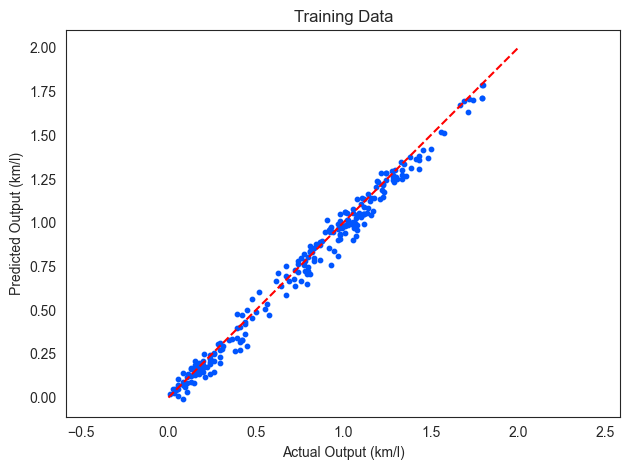

In [34]:
plt.scatter(y_train, y_train_pred, s=10)
plt.plot([0, 2], [0,2], color = 'red', linestyle='dashed')

plt.xlabel('Actual Output (km/l)')
plt.ylabel('Predicted Output (km/l)')
plt.axis('equal')
plt.title('Training Data')
plt.tight_layout()

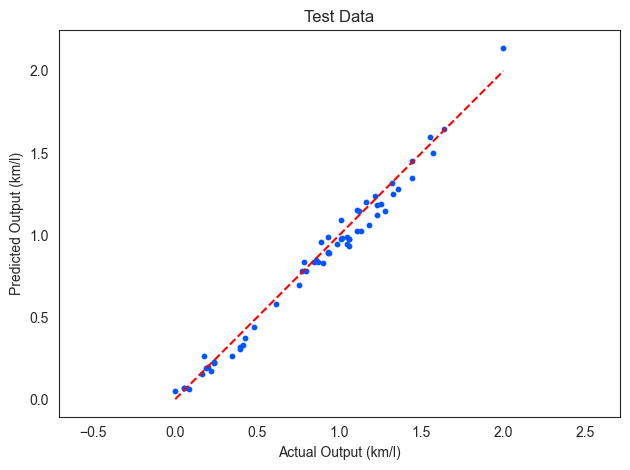

In [35]:
plt.scatter(y_test, y_test_pred, s=10)
plt.plot([0, 2], [0,2], color = 'red', linestyle='dashed')
plt.xlabel('Actual Output (km/l)')
plt.ylabel('Predicted Output (km/l)')
plt.axis('equal')
plt.title('Test Data')
plt.tight_layout()

## Calculating the metrics

In [36]:
train_mae =  np.round(mean_absolute_error(y_train, y_train_pred),3 )
train_mse =  np.round(mean_squared_error(y_train, y_train_pred),3)
train_rmse = np.round(np.sqrt(train_mse),3)

print('COMPARISON OF METRICS - TRAINING DATA')
print(f'Training MAE   : {train_mae}')
print(f'Training MSE   : {train_mse}')
print(f'Training RMSE  : {train_rmse}')

COMPARISON OF METRICS - TRAINING DATA
Training MAE   : 0.046
Training MSE   : 0.003
Training RMSE  : 0.055


In [37]:
test_mae =  np.round(mean_absolute_error(y_test, y_test_pred),3) 
test_mse =  np.round(mean_squared_error(y_test, y_test_pred),3)
test_rmse = np.round(np.sqrt(test_mse),3)

print('COMPARISON OF METRICS - TEST DATA')
print(f'Testing MAE   : {test_mae}')
print(f'Testing MSE   : {test_mse}')
print(f'Testing RMSE  : {test_rmse}')

COMPARISON OF METRICS - TEST DATA
Testing MAE   : 0.053
Testing MSE   : 0.004
Testing RMSE  : 0.063
